# Crash look at UK road traffic accident data

In [1]:
# Imports
# Data Processing
from time import time
import numpy as np
import pandas as pd

# Modelling
from sklearn.neighbors import KDTree
from sklearn.cluster import DBSCAN, OPTICS
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn

# Visualisation Packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Read up the data

In [2]:
######### Read up accidents
accidents_2019 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Accidents_2019.zip",low_memory=False, compression='zip')
accidents_2018 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Accidents_2018.csv",low_memory=False)
accidents_2017 = pd.read_csv(r"http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Accidents_2017.zip",low_memory=False, compression='zip')
accidents_2016 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafety_Accidents_2016.zip",low_memory=False, compression='zip')
accidents_2015 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/RoadSafetyData_Accidents_2015.zip",low_memory=False, compression='zip')
accidents_2014 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Accidents_2014.zip",low_memory=False)

######### Read up casualties
casualties_2019 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Casualties_2019.zip",low_memory=False, compression='zip')
casualties_2018 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Casualties_2018.csv",low_memory=False)
casualties_2017 = pd.read_csv(r"http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Casualties_2017.zip",low_memory=False, compression='zip')
casualties_2016 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Casualties_2016.zip",low_memory=False, compression='zip')
casualties_2015 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/RoadSafetyData_Casualties_2015.zip",low_memory=False, compression='zip')
casualties_2014 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Casualties_2014.zip",low_memory=False, compression='zip')

######### Read up vehicles
vehicles_2019 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Vehicles_2019.zip",low_memory=False, compression='zip')
vehicles_2018 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Vehicles_2018.csv",low_memory=False)
vehicles_2017 = pd.read_csv(r"http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Vehicles_2017.zip",low_memory=False, compression='zip')
vehicles_2016 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Vehicles_2016.zip",low_memory=False, compression='zip')
vehicles_2015 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/RoadSafetyData_Vehicles_2015.zip",low_memory=False, compression='zip')
vehicles_2014 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Vehicles_2014.zip",low_memory=False, compression='zip')

df_accidents = accidents_2019.append([accidents_2018, accidents_2017, accidents_2016, accidents_2015], sort=False)
df_vehicles = vehicles_2019.append([vehicles_2018, vehicles_2017, vehicles_2016, vehicles_2015], sort=False)
df_casualties = casualties_2019.append([casualties_2018, casualties_2017, casualties_2016, casualties_2015], sort=False)


In [3]:
df_accidents.head(2)

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,18/02/2019,...,0,5,1,1,1,0,0,1,3,E01004762
1,2019010152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,15/01/2019,...,-1,-1,4,1,1,0,0,1,3,E01003117


In [4]:
print(len(df_accidents))
df_accidents.describe()

646830


,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),...,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
count,646694.000000,6.466940e+05,646684.000000,646684.000000,646830.000000,646830.00000,646830.000000,646830.000000,646830.000000,646830.000000,...,646830.000000,646830.000000,646830.000000,646830.000000,646830.000000,646830.000000,646830.00000,646830.000000,646830.000000,646830.000000
mean,449991.668522,2.849132e+05,-1.285440,52.451565,29.014908,2.80286,1.842928,1.317689,4.105054,334.292142,...,318.008089,0.002631,0.841988,2.002769,1.592154,1.287106,0.08193,0.051386,1.335193,1.276924
std,95113.941751,1.546867e+05,1.395652,1.393169,25.032437,0.42894,0.714437,0.774821,1.920978,258.027429,...,1185.416554,0.217367,1.958599,1.696483,1.728265,0.596729,0.66823,0.551928,0.472396,0.490678
min,64084.000000,1.023500e+04,-7.525273,49.912362,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000
25%,386786.250000,1.760760e+05,-2.198493,51.471246,5.000000,3.00000,1.000000,1.000000,2.000000,93.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000
50%,455964.000000,2.272940e+05,-1.173459,51.928157,23.000000,3.00000,2.000000,1.000000,4.000000,307.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000
75%,528380.000000,3.889300e+05,-0.149825,53.394286,45.000000,3.00000,2.000000,1.000000,6.000000,514.000000,...,0.000000,0.000000,0.000000,4.000000,1.000000,2.000000,0.00000,0.000000,2.000000,2.000000
max,655391.000000,1.209512e+06,1.759641,60.763722,98.000000,3.00000,37.000000,59.000000,7.000000,941.000000,...,9999.000000,2.000000,8.000000,7.000000,9.000000,5.000000,7.00000,7.000000,3.000000,3.000000


In [5]:
def ToCategorical(df, col_name_list, category_dict_list):
    '''
    Converts the given columns to categorical data type with the correct categories
    used from the category_dict_list
    
    Parameters:
    df (Pandas DataFrame): Input dataframe with columns to convert to categorical type
    col_name_list  (list): List of column names from df. These columns will be converted
    category_dict_list (list): a list of dictionaries. each dictioanry corresponds to the respective column
       and holds the correct category names to use.

    Returns:
    DataFrame with categorical columns 
    '''
    
    df_out = df.copy()
    
    for i,col in enumerate(col_name_list):
        df_out[col] = df_out[col].astype('category')
        df_out[col].cat.categories = [category_dict_list[i][j] for j in df_out[col].cat.categories]
        
    return df_out

## 1. Is transport becoming safer?

In [6]:
df_accidents["Time stamp"] = pd.DatetimeIndex(df_accidents["Date"] + " " + df_accidents["Time"], dayfirst=True)
df_accidents["Year"] = df_accidents["Time stamp"].dt.year.astype('Int16')

df_casualties_date = df_casualties.merge(df_accidents[["Accident_Index","Time stamp"]], left_on="Accident_Index",right_on="Accident_Index",how='left')
df_casualties_date["Year"] = df_casualties_date["Time stamp"].dt.year

In [7]:
df_accidents_by_year = df_accidents["Year"].value_counts()
df_accidents_by_year

2015    140038
2016    136619
2017    129979
2018    122622
2019    117473
Name: Year, dtype: Int64

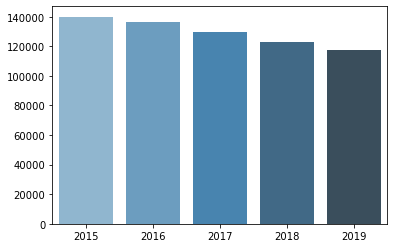

In [8]:
sns.barplot(y=df_accidents_by_year.values, x=df_accidents_by_year.index, palette="Blues_d");

In [9]:
# How does the number of casualities change
severity = {1:'Fatal',2:'Serious',3:'Slight'}
df_casualties_date = ToCategorical(df_casualties_date, ['Casualty_Severity'], [severity])

df_casualties_by_year = df_casualties_date.groupby(by=['Casualty_Severity','Year'], as_index=False)['Accident_Index'].count()

In [10]:
df_casualties_by_year.head(2)

,Casualty_Severity,Year,Accident_Index
0,Fatal,2015.0,1728
1,Fatal,2016.0,1792


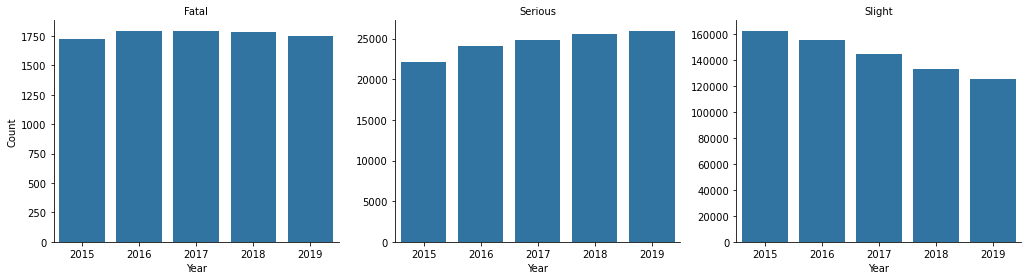

In [11]:
g = sns.FacetGrid(df_casualties_by_year, col="Casualty_Severity", sharey=False, height=4,
    aspect=1.2,)
g.map(sns.barplot, "Year", "Accident_Index", order=[2015,2016,2017,2018,2019])
g.set_axis_labels(y_var='Count')
g.set_titles(col_template = '{col_name}');

## 2. Are young drivers involved in more accidents?

In [15]:
df_vehicles_age = df_vehicles[df_vehicles['Age_Band_of_Driver']>0].copy()

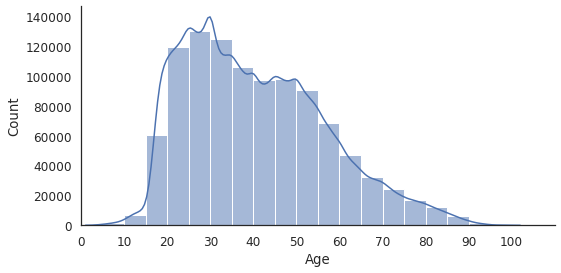

In [16]:
sns.set(font_scale=1.1)
sns.set_style("white")
fig = sns.displot(df_vehicles_age, x='Age_of_Driver', kind='hist', bins=list(range(0,110,5)), kde=True,
              height=4, aspect=2)
fig.set(xlim=(0, 110), xlabel=('Age'), xticks=list(range(0,110,10)))


## 3. Are female drivers involved in more accidents then men?

https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/905926/nts0206.ods

In [17]:
# Map ccategories
gender = {1:'Male',2:'Female', 3:'Not known', -1:'Data missing or out of range'}
df_vehicles_age_sex = ToCategorical(df_vehicles_age, ['Sex_of_Driver'], [gender])

df_vehicles_age_sex['Sex_of_Driver'].value_counts()

Male                            721936
Female                          314998
Not known                         9327
Data missing or out of range         8
Name: Sex_of_Driver, dtype: int64

In [18]:
df_vehicles_age_sex['Sex_of_Driver'].cat.remove_categories(['Not known','Data missing or out of range'], inplace=True)

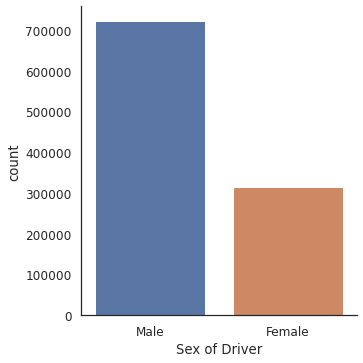

In [19]:
fig = sns.catplot(x="Sex_of_Driver", kind="count", data=df_vehicles_age_sex)
fig.set_xlabels('Sex of Driver') # , fontsize=12

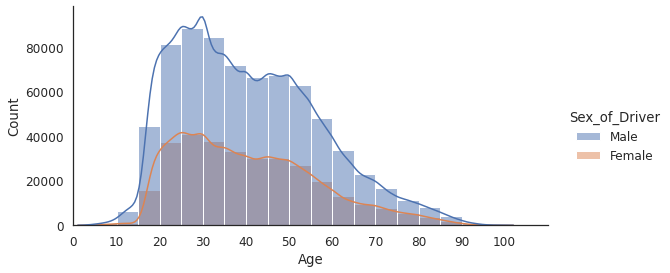

In [20]:
fig = sns.displot(df_vehicles_age_sex, x='Age_of_Driver', hue='Sex_of_Driver',
                  kind='hist', bins=list(range(0,110,5)), kde=True, height=4, aspect=2)
fig.set(xlim=(0, 110), xlabel=('Age'), xticks=list(range(0,110,10)))

In [21]:
# Get the number of accidents with 1) only male driver, 2) only female driver, 3) both male and female male driver involved

# Filter to accidents where we have data for all vehicles 

# Groupby to categorise these

def gender_cat(array_like):
    pass

## 3b Are certain road types more dangerous?

## 4. Are injuries more severe in certain weather conditions?

In [23]:
condition_cols = ['Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions']

df_casualties_conditions = df_casualties.merge(df_accidents[['Accident_Index'] + condition_cols], on='Accident_Index', how='left')

In [24]:
light_dict = {1:'Daylight',4:'Darkness - lights lit',5:'Darkness - lights unlit',6:'Darkness - no lighting',7:'Darkness - lighting unknown',-1:'Data missing or out of range'}
weather_dict ={1:'Fine no high winds',2:'Raining no high winds',3:'Snowing no high winds',4:'Fine + high winds',5:'Raining + high winds',6:'Snowing + high winds',7:'Fog or mist',8:'Other',9:'Unknown',-1:'Data missing or out of range'}
surface_dict = {1:'Dry',2:'Wet or damp',3:'Snow',4:'Frost or ice',5:'Flood over 3cm. deep',6:'Oil or diesel',7:'Mud',-1:'Data missing or out of range'}

df_casualties_conditions = ToCategorical(df_casualties_conditions, condition_cols + ['Casualty_Severity'], [light_dict, weather_dict, surface_dict, severity])


In [25]:
df_casualties_conditions['Light_Conditions'].value_counts()

Daylight                        609989
Darkness - lights lit           171715
Darkness - no lighting           49966
Darkness - lighting unknown      14965
Darkness - lights unlit           5664
Data missing or out of range        22
Name: Light_Conditions, dtype: int64

In [26]:
df_casualties_conditions['Weather_Conditions'].value_counts()

Fine no high winds              688715
Raining no high winds            97149
Unknown                          21277
Other                            16122
Raining + high winds             10247
Fine + high winds                 9739
Fog or mist                       3983
Snowing no high winds             3901
Snowing + high winds              1145
Data missing or out of range        43
Name: Weather_Conditions, dtype: int64

In [27]:
df_casualties_conditions['Road_Surface_Conditions'].value_counts()

Dry                             609801
Wet or damp                     220880
Frost or ice                     10916
Data missing or out of range      6176
Snow                              3468
Flood over 3cm. deep              1080
Name: Road_Surface_Conditions, dtype: int64

In [28]:
df_casualties_conditions.pivot_table(index=['Light_Conditions'],
                                     columns=['Casualty_Severity'],
                                     values=['Accident_Index'],aggfunc='count')

Accident_Index                
Casualty_Severity                     Fatal Serious  Slight
Light_Conditions                                           
Data missing or out of range              1       1      20
Daylight                               5156   83770  521063
Darkness - lights lit                  1750   25836  144129
Darkness - lights unlit                  97     959    4608
Darkness - no lighting                 1677   10040   38249
Darkness - lighting unknown             170    1926   12869

In [29]:
def KSI_proportion(df, cols):
    '''
    
    '''
    df_out = pd.DataFrame(columns=cols + ['KSI'])
    
    # Single column
    for i in range(len(cols)):
        
        col = cols[i]
        
        df_counts = df.value_counts(subset=[col, 'Casualty_Severity']).unstack()
        df_ksi_props = df_counts[['Fatal', 'Serious']].sum(1) / df_counts.sum(axis=1)
        
        df_out = df_out.append(df_ksi_props.to_frame(name='KSI').reset_index())
        
        # Combination of two columns
        for col_two in cols[i+1:]:
            
            df_counts = df.value_counts(subset=[col, col_two, 'Casualty_Severity']).unstack()
            df_ksi_props = df_counts[['Fatal', 'Serious']].sum(1) / df_counts.sum(axis=1)

            df_out = df_out.append(df_ksi_props.to_frame(name='KSI').reset_index())    
    
    # All three columns:
    df_counts = df.value_counts(subset=cols+['Casualty_Severity']).unstack()
    df_ksi_props = df_counts[['Fatal', 'Serious']].sum(1) / df_counts.sum(axis=1)

    df_out = df_out.append(df_ksi_props.to_frame(name='KSI').reset_index())
            
    return df_out

In [30]:
# df_casualties_conditions.groupby(by=['Light_Conditions'])['Casualty_Severity'].apply(KSI_Percentage)

df_ksi_light = df_casualties_conditions.value_counts(subset=['Light_Conditions', 'Casualty_Severity']).unstack()
df_ksi_light[['Fatal', 'Serious']].sum(1) / df_ksi_light.sum(axis=1)

df_ksi_weather = df_casualties_conditions.value_counts(subset=['Weather_Conditions', 'Casualty_Severity']).unstack()
df_ksi_weather[['Fatal', 'Serious']].sum(1) / df_ksi_weather.sum(axis=1)

df_ksi_surface = df_casualties_conditions.value_counts(subset=['Road_Surface_Conditions', 'Casualty_Severity']).unstack()
test = df_ksi_surface[['Fatal', 'Serious']].sum(1) / df_ksi_surface.sum(axis=1)

In [31]:
df_ksi_props = KSI_proportion(df_casualties_conditions, condition_cols) #.sort_values(by='KSI')
df_ksi_props.head()

,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,KSI
0,Data missing or out of range,NaN,NaN,0.090909
1,Daylight,NaN,NaN,0.145783
2,Darkness - lights lit,NaN,NaN,0.160650
3,Darkness - lights unlit,NaN,NaN,0.186441
4,Darkness - no lighting,NaN,NaN,0.234499


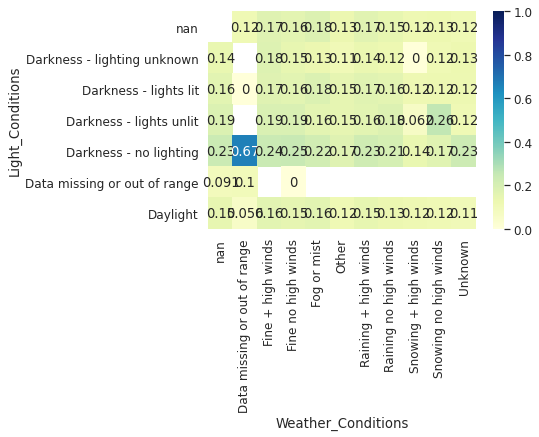

In [32]:
df_light_weather = df_ksi_props[df_ksi_props['Road_Surface_Conditions'].isnull()].pivot(values='KSI',
                   index='Light_Conditions',
                   columns='Weather_Conditions')

sns.heatmap(df_light_weather, annot=True, cmap="YlGnBu", vmin=0, vmax=1);

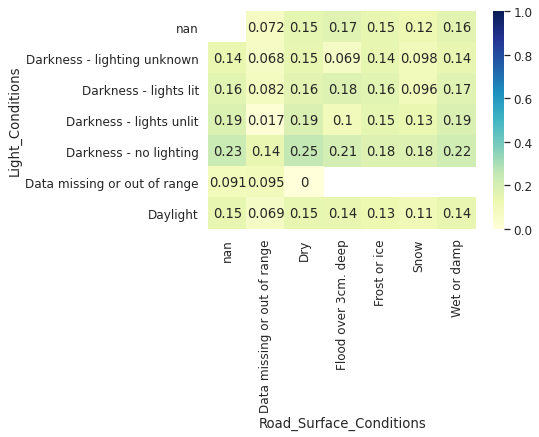

In [33]:
df_light_surface = df_ksi_props[df_ksi_props['Weather_Conditions'].isnull()].pivot(values='KSI',
                   index='Light_Conditions',
                   columns='Road_Surface_Conditions')

sns.heatmap(df_light_surface, annot=True, cmap="YlGnBu", vmin=0, vmax=1);

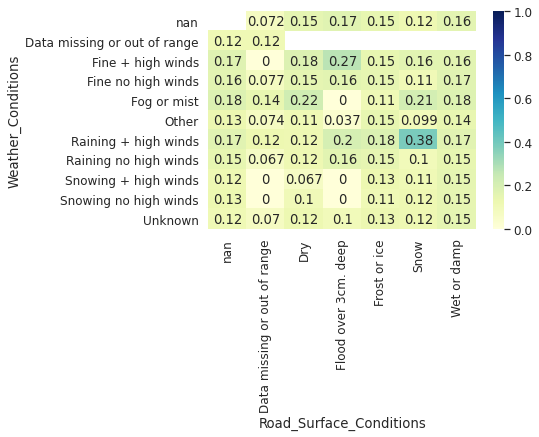

In [34]:
df_weather_surface = df_ksi_props[df_ksi_props['Light_Conditions'].isnull()].pivot(values='KSI',
                   index='Weather_Conditions',
                   columns='Road_Surface_Conditions')

sns.heatmap(df_weather_surface, annot=True, cmap="YlGnBu", vmin=0, vmax=1);

## 5. can we find the worst accident hot spot locations?

https://towardsdatascience.com/how-to-embed-interactive-charts-on-your-medium-articles-and-website-6987f7b28472#:~:text=Embed%20in%20Medium&text=Using%20Datapane's%20API%2C%20you%20can,and%20embed%20it%20into%20Medium.&text=Once%20you%20have%20logged%20in,single%20Plot%20component%20in%20it.
https://andrewpwheeler.com/2015/09/03/using-kdtrees-in-python-to-calculate-neighbor-counts/

In [35]:
df_accidents_coords = df_accidents[['Accident_Index','Location_Easting_OSGR','Location_Northing_OSGR']].copy()

print(len(df_accidents_coords[df_accidents_coords.isnull().any(1)]))
df_accidents_coords_complete = df_accidents_coords.dropna().copy()

df_accidents_coords_complete[['Location_Easting_OSGR','Location_Northing_OSGR']] = df_accidents_coords_complete[['Location_Easting_OSGR','Location_Northing_OSGR']].astype('Int32')
accident_array = df_accidents_coords_complete.values

136


In [48]:
accident_tree = KDTree(accident_array[:,1:3])

rank_cols = []

for dist in range(50,215,15):
    df_accidents_coords_complete.loc[:,'Neighbour ' + str(dist)+ 'm'] = accident_tree.query_radius(accident_array[:,1:3],
                                                                                   r=dist,
                                                                                   count_only=True)
    
    df_accidents_coords_complete.loc[:,'Neighbour ' + str(dist) + 'm rank'] = df_accidents_coords_complete.loc[:,'Neighbour ' + str(dist)+ 'm'].rank(ascending=False)
    
    rank_cols.append('Neighbour ' + str(dist) + 'm rank')
#     df_accidents_coords_complete.sort_values(by='NeighbourNO', ascending=False).reset_index()[:20]

In [49]:
df_accidents_coords_complete['Av Rank'] = df_accidents_coords_complete[rank_cols].mean(axis=1)

In [53]:
df_accidents_coords_complete.sort_values(by=['Av Rank'], ascending=True).head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,NeighbourNO,Neighbour 50m,Neighbour 50m rank,Neighbour 65m,Neighbour 65m rank,Neighbour 80m,Neighbour 80m rank,...,Neighbour 140m rank,Neighbour 155m,Neighbour 155m rank,Neighbour 170m,Neighbour 170m rank,Neighbour 185m,Neighbour 185m rank,Neighbour 200m,Neighbour 200m rank,Av Rank
6436,2018010101667,531950,179110,81,68,196.5,79,153.0,105,6.0,...,40.5,174,69.5,184,116.0,202,93.0,211,126.0,77.272727
18633,2019010209987,531956,179103,86,62,417.0,78,187.5,107,4.0,...,40.5,175,60.0,190,61.5,204,83.0,212,120.0,90.818182
7863,2019010179199,531947,179105,89,64,369.5,78,187.5,110,3.0,...,40.5,174,69.5,187,83.0,202,93.0,212,120.0,91.909091
17177,2017010056466,531960,179110,84,62,417.0,79,153.0,97,25.5,...,40.5,175,60.0,187,83.0,203,88.5,212,120.0,93.818182
17292,2018010132569,531950,179120,81,67,254.5,80,104.0,91,88.5,...,50.0,171,107.5,185,101.0,197,125.5,210,139.5,94.772727


### Try DBSCAN

In [ ]:
X_std = StandardScaler().fit_transform(accident_array[:,1:3])
X = np.array(accident_array[:,1:3], dtype='int32')

In [ ]:
sns.scatterplot(x=X[:,0], y=X[:,1])
plt.axis('equal')

In [ ]:
# Compute DBSCAN
db = DBSCAN(eps=15, min_samples=40, n_jobs=8).fit(X)
labels = db.labels_
len(np.unique(labels))

In [ ]:
df_accidents_coords_complete['Cluster No'] = labels

In [ ]:
plt.figure(figsize=[25,25])

plt.axis('equal')
plt.grid()

# '#e91e63'
plt.scatter(df_accidents_coords_complete["Location_Easting_OSGR"],
            df_accidents_coords_complete["Location_Northing_OSGR"],
            c='#37474F', s=0.4,
            alpha=0.5, label="Accidents")

# '#37474F'
plt.scatter(df_accidents_coords_complete.loc[df_accidents_coords_complete['Cluster No']>0,"Location_Easting_OSGR"],
            df_accidents_coords_complete.loc[df_accidents_coords_complete['Cluster No']>0,"Location_Northing_OSGR"],
            c=df_accidents_coords_complete.loc[df_accidents_coords_complete['Cluster No']>0,'Cluster No'],
            s=20, label="Cluster of accidents")

plt.title('Accidents')

# plt.ylim(0,200000)
# plt.xlim(100000,350000)

plt.xlabel('OSGR Easting [m]')
plt.ylabel('OSGR Northing [m]')
plt.yticks([50000,100000,150000,200000,250000,300000])
#plt.grid(linestyle=':')
plt.grid(False)
plt.legend(prop={'size': 16})

In [ ]:
df_accidents_coords_complete.loc[df_accidents_coords_complete['Cluster No']==2,:]
df_accidents = df_accidents.merge(df_accidents_coords_complete[['Accident_Index', 'Cluster No']],
                                  left_on='Accident_Index', right_on='Accident_Index', how='left')

In [ ]:
df_accidents.head()
df_accident_clusters = df_accidents[df_accidents['Cluster No']>-1].copy()
len(df_accident_clusters)

In [ ]:
label_to_look_at = 1

In [ ]:
plt.figure(figsize=[25,25])
plt.axis('equal')
plt.grid()

df_accidents_to_look_at = df_accidents[df_accidents['Cluster No']==label_to_look_at].copy()


plt.scatter(df_accidents["Location_Easting_OSGR"],
            df_accidents["Location_Northing_OSGR"],
            c='#37474F', s=0.4,
            alpha=0.5, label="Accidents")

# '#37474F'
plt.scatter(df_accidents_to_look_at["Location_Easting_OSGR"],
            df_accidents_to_look_at["Location_Northing_OSGR"],
            c='#e91e63',
            s=20, label="Cluster of accidents")

plt.title('Accidents')

plt.ylim(df_accidents_to_look_at["Location_Northing_OSGR"].min()-100,df_accidents_to_look_at["Location_Northing_OSGR"].max()+100)
plt.xlim(df_accidents_to_look_at["Location_Easting_OSGR"].min()-100,df_accidents_to_look_at["Location_Easting_OSGR"].max()+100)

plt.xlabel('OSGR Easting [m]')
plt.ylabel('OSGR Northing [m]')
# plt.yticks([50000,100000,150000,200000,250000,300000])
#plt.grid(linestyle=':')
plt.grid(False)
plt.legend(prop={'size': 16})

In [ ]:
fig = px.scatter_mapbox(df_accident_clusters, lat="Latitude", lon="Longitude",
                        hover_name="Cluster No", hover_data=["Accident_Severity", "Number_of_Casualties"],
                        color_discrete_sequence=["fuchsia"], zoom=5, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
df_accident_clusters.head()

## Try Optics

In [ ]:
start_time = time()
optics_clustering = OPTICS(min_samples=40, max_eps=25, metric='euclidean', n_jobs=8).fit(X)

end_time = time()
print((end_time-start_time))

In [ ]:
optics_labels = optics_clustering.labels_
print(len(np.unique(optics_labels)))

df_accidents_coords_complete['OPTICS Cluster No'] = optics_labels

df_accidents = df_accidents.merge(df_accidents_coords_complete[['Accident_Index', 'OPTICS Cluster No']],
                                  left_on='Accident_Index', right_on='Accident_Index', how='left')

In [ ]:
df_accidents.head()

In [ ]:
df_accident_clusters = df_accidents[df_accidents['OPTICS Cluster No_y']>-1].copy()
len(df_accident_clusters)

In [ ]:
fig = px.scatter_mapbox(df_accident_clusters, lat="Latitude", lon="Longitude",
                        hover_name='OPTICS Cluster No_y', hover_data=["Accident_Severity", "Number_of_Casualties"],
                        color_discrete_sequence=["fuchsia"], zoom=5, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Can we estimate the number of casualities and respective severity?

A witness would know:
- Location
- type of Vehicles
- Date/time
- Surface conditions

Out of those what would be relevant?

What are we trying to estimate?
<br>
number of casualities with severity?
get a single estimation with a vector of 3 elements: number of slight, serious, fatal
 - Multivariate Linear Regression
 - ## Let's use ANN

- Veh Leaving Carriageway

<br>get a model for each vehicle?

In [ ]:
accident_features = ['Accident_Index','Road_Type','Speed_limit','Junction_Detail','Junction_Control',
                     'Light_Conditions','Weather_Conditions','Road_Surface_Conditions','Urban_or_Rural_Area']

vehicle_features = ['Vehicle_Type']
# Veh Leaving Carriageway

In [ ]:
df_vehicle_classes = df_vehicles.groupby(['Accident_Index','Vehicle_Type']).size().unstack(fill_value=0)
print(len(df_vehicle_classes))

In [ ]:
casaualty_severity = df_casualties.groupby(['Accident_Index','Casualty_Severity']).size().unstack(fill_value=0)
casaualty_severity.rename(columns={1: "Fatal", 2: "Serious", 3: "Slight"}, inplace=True)
casaualty_severity.head()

In [ ]:
print(len(df_accidents[accident_features]))
df_accidents_s1 = df_accidents[accident_features].merge(df_vehicle_classes, on="Accident_Index")
df_accidents_s2 = df_accidents_s1.merge(casaualty_severity, on="Accident_Index")

In [ ]:
# simply drop NA
df_accidents_s3 = df_accidents_s2.drop(df_accidents_s2[df_accidents_s2.isnull().any(1)].index)

# simply drop negatives:
value_cols = ['Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions',
 'Urban_or_Rural_Area', -1, 1, 2, 3, 4, 5, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 90, 97, 98, 'Fatal',
 'Serious', 'Slight']

df_accidents_s3.loc[df_accidents_s3['Junction_Control']==-1, 'Junction_Control'] = 5
df_accidents_s3.loc[df_accidents_s3['Junction_Detail']==-1, 'Junction_Detail'] = 10
df_accidents_s3.loc[df_accidents_s3['Road_Surface_Conditions']==-1, 'Road_Surface_Conditions'] = 8

df_accidents_s3.loc[df_accidents_s3['Light_Conditions']==-1, 'Light_Conditions'] = 8
df_accidents_s3.loc[df_accidents_s3['Weather_Conditions']==-1, 'Weather_Conditions'] = 9

df_accidents_s3.loc[df_accidents_s3['Road_Type']==-1, 'Road_Type'] = 9
df_accidents_s3.loc[df_accidents_s3['Urban_or_Rural_Area']==-1, 'Urban_or_Rural_Area'] = 3

In [ ]:
df_accidents_s3[(df_accidents_s3[value_cols] < 0).any(1)]

In [ ]:
x_cont_cols = ['Speed_limit', -1, 1, 2, 3, 4, 5, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 90, 97, 98]

x_cat_cols = ['Road_Type', 'Junction_Detail', 'Junction_Control', 'Light_Conditions',
              'Weather_Conditions', 'Road_Surface_Conditions', 'Urban_or_Rural_Area']

label_cols = ['Fatal', 'Serious', 'Slight']

In [ ]:
X = torch.tensor(df_accidents_s3[x_cont_cols + x_cat_cols].values, dtype=torch.float)
x_cont = torch.tensor(df_accidents_s3[x_cont_cols].values, dtype=torch.float)

df_accidents_s3[x_cat_cols] = df_accidents_s3[x_cat_cols].astype("category")
x_cat = torch.tensor( np.stack( [df_accidents_s3[col].cat.codes.values for col in x_cat_cols], axis=1), dtype=torch.int)

In [ ]:
x_cat.shape

In [ ]:
y = torch.tensor(df_accidents_s3[label_cols].values, dtype=torch.float)

## Train test split

<div class="alert alert-block alert-danger">
<b>Danger:</b> 

ADD SHUFFLING


</div>

In [ ]:
cat_train = x_cat[:batch_size-test_size]
cat_test = x_cat[batch_size-test_size:batch_size]
con_train = x_cont[:batch_size-test_size]
con_test = x_cont[batch_size-test_size:batch_size]

In [ ]:
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

### Setting up Model

In [ ]:
class RegressionModel(nn.Module):
    
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.35):
        
        super().__init__()
        
        # Embedding
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        
        # Dropout layer
        self.emb_drop = nn.Dropout(p)
        
        # normalise the continous data
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum([nf for ni,nf in emb_szs])
        n_in = n_emb + n_cont
        
        # Create list of fully connected layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        
        # fully connected layer
        layerlist.append(nn.Linear(layers[-1], out_sz))
        
        
        self.layers = nn.Sequential(*layerlist)
        
        
    def forward(self, x_cat, x_cont):
        
        embeddings = []
                
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        # Concatenate individial vectors of categorical columns from embeddings    
        x = torch.cat(embeddings, 1)
        # Apply dropout
        x = self.emb_drop(x)
        
        # Normalise continous data
        x_cont = self.bn_cont(x_cont)
        
        # Concatenate categorical and continous columns
        x = torch.cat([x,x_cont],1)
        # Pass through tensor the fully connected layers
        x = self.layers(x)
        
        return x

In [ ]:
torch.manual_seed(42)
model = RegressionModel(emb_szs, len(x_cont_cols), 3, [200,100,60], p=0.4)

criterion = nn.MSELoss() # np.sqrt(MSE) --> RMS

optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 60000
test_size = int(batch_size * 0.2)

In [ ]:
start_time = time()

epochs = 300

losses = []

for i in range(epochs):
    i+=1
    
    y_pred = model(cat_train,con_train)
    y_pred = torch.round(y_pred)
    loss = torch.sqrt(criterion(y_pred, y_train))
    
    losses.append(loss)
    
    if i%10 == 1:
        print(f'epoch: {i} loss is {loss}')
        
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
end_time = time()
duration = end_time - start_time
print(f'Traning took {duration/60} minutes')

In [ ]:
torch.round(y_pred)

In [ ]:
plt.plot(range(epochs), losses)

In [ ]:
with torch.no_grad():
    
    y_val = model(cat_test,con_test)
    
    loss = torch.sqrt(criterion(y_val, y_test))

In [ ]:
loss

In [ ]:
for i in range(10):
    
    print(f'{i}.) Predicted: {y_val[i]} TRUE: {y_test[i]}')